In [36]:
import numpy as np
from nbodykit.lab import BigFileMesh, BigFileCatalog
from pmesh.pm import ParticleMesh
import os, sys
import matplotlib.pyplot as plt
%matplotlib inline
import importlib


In [85]:
sys.path.append('/global/homes/c/chmodi/Programs/cosmo4d/train_nets-tflow/')
import tools 

sys.path.append('/global/homes/c/chmodi/Programs/cosmo4d/train_nets/')
import features as ft

importlib.reload(ft)

<module 'features' from '/global/homes/c/chmodi/Programs/cosmo4d/train_nets/features.py'>

In [3]:
bs = 400
nc = 128
ncf = 512
step = 5
stepf = 40
path = '/project/projectdirs/astro250/chmodi/cosmo4d/data/z00/'
pm = ParticleMesh(BoxSize=bs, Nmesh = [nc, nc, nc])


In [4]:
seed = 100
mesh = BigFileMesh(path + 'L%04d_N%04d_S%04d_%02dstep/mesh'%(bs, nc, seed, step), 's').paint()
meshf = BigFileMesh(path + 'L%04d_N%04d_S%04d_%02dstep/mesh'%(bs, ncf, seed, stepf), 's').paint()
cat = BigFileCatalog(path + 'L%04d_N%04d_S%04d_%02dstep/FOF'%(bs, ncf, seed, stepf))

In [18]:
# def readhead(path):
#     shape = None
#     with open(path +'attr-v2') as  f:
#         for line in f.readlines():
#             if 'ndarray.shape' in line: 
#                 shape = tuple(int(i) for i in line.split('[')[1].split()[:-1])
#     with open(path +'header') as  f:
#         for line in f.readlines():
#             if 'DTYPE' in line: dtype = line.split()[-1]
#             if 'NFILE' in line: nf = int(line.split()[-1])
#             if 'NMEMB' in line: 
#                 if shape is None: shape = tuple([-1, int(line.split()[-1])])
#     return dtype, nf, shape


# def readfile(path):
#     dtype, nf, shape = readhead(path)
#     data = []
#     for i in range(nf): data.append(np.fromfile(path + '%06d'%i, dtype=dtype))
#     data = np.concatenate(data)
#     data = np.reshape(data, shape)
#     return data

# ar = readfile(path + 'L%04d_N%04d_S%04d_%02dstep/mesh/s/'%(bs, nc, seed, step)).reshape(nc, nc, nc)
# arf = readfile(path + 'L%04d_N%04d_S%04d_%02dstep/mesh/s/'%(bs, ncf, seed, stepf)).reshape(ncf, ncf, ncf)
# peakpos = readfile(path + 'L%04d_N%04d_S%04d_%02dstep/FOF/PeakPosition/'%(bs, ncf, seed, stepf)).reshape(-1, 3)
# cmvel = readfile(path + 'L%04d_N%04d_S%04d_%02dstep/FOF/CMVelocity/'%(bs, ncf, seed, stepf)).reshape(-1, 3)
# mass = readfile(path + 'L%04d_N%04d_S%04d_%02dstep/FOF/Length/'%(bs, ncf, seed, stepf)).reshape(-1)

ar = tools.readbigfile(path + 'L%04d_N%04d_S%04d_%02dstep/mesh/s/'%(bs, nc, seed, step))
arf = tools.readbigfile(path + 'L%04d_N%04d_S%04d_%02dstep/mesh/s/'%(bs, ncf, seed, stepf))
peakpos = tools.readbigfile(path + 'L%04d_N%04d_S%04d_%02dstep/FOF/PeakPosition/'%(bs, ncf, seed, stepf))
cmvel = tools.readbigfile(path + 'L%04d_N%04d_S%04d_%02dstep/FOF/CMVelocity/'%(bs, ncf, seed, stepf))
mass = tools.readbigfile(path + 'L%04d_N%04d_S%04d_%02dstep/FOF/Length/'%(bs, ncf, seed, stepf)).reshape(-1)

In [19]:
mass.shape

(421286,)

In [20]:
hmesh = pm.paint(peakpos, mass=mass.reshape(-1))


In [22]:
abs(ar - mesh).csum()

0.0

In [23]:
abs(mass - cat['Length'].compute()).sum()

/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/dask/base.py:828: UserWarning: The get= keyword has been deprecated. Please use the scheduler= keyword instead with the name of the desired scheduler like 'threads' or 'processes'
  warnings.warn("The get= keyword has been deprecated. "


0

In [24]:
hmeshp = pm.paint(peakpos)
hmesh = pm.paint(peakpos, mass=mass)

hmeshpnn = pm.paint(peakpos, resampler='nearest')
hmeshnn = pm.paint(peakpos, mass=mass, resampler='nearest')

shift = -0.5*bs/nc*np.ones_like(peakpos)
hmeshpnn2 = pm.paint(peakpos + shift, resampler='nearest')
hmeshnn2 = pm.paint(peakpos + shift, mass=mass, resampler='nearest')


In [25]:

tmpp = tools.paintcic(peakpos, bs, nc)
tmp = tools.paintcic(peakpos, bs, nc, mass=mass.reshape(-1))

tmppnn = tools.paintnn(peakpos, bs, nc)
tmpnn = tools.paintnn(peakpos, bs, nc, mass=mass.reshape(-1))

In [26]:
abs(tmpp - hmeshp[...]).max()

2.1629595901906384e-05

In [27]:
tmppnn.sum(), hmeshpnn[...].sum(), (tmppnn - hmeshpnn[...]).sum(), (tmppnn - hmeshpnn2[...]).sum()

(421286.0, 421286.0, 0.0, 0.0)

In [28]:
abs(tmppnn - hmeshpnn[...]).sum(), abs(tmppnn - hmeshpnn2[...]).sum()

(0.0, 581926.0)

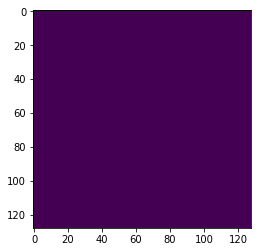

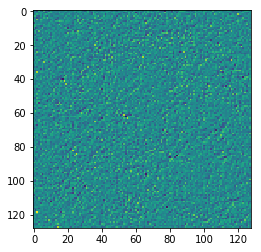

In [29]:
plt.imshow((tmppnn-hmeshpnn)[...].sum(axis=0))
plt.show()
plt.imshow((tmppnn-hmeshpnn2)[...].sum(axis=0))
plt.show()


In [30]:
abs(tmpnn - hmeshnn[...]).sum(), abs(tmpnn - hmeshnn2[...]).sum()

(0.0, 78054944.0)

In [31]:
abs(tmpnn - hmeshnn[...]).max(), abs(tmpnn - hmeshnn2[...]).max()

(0.0, 47800.0)

In [32]:
(abs(tmpnn - hmeshnn[...]) >1).sum()

0

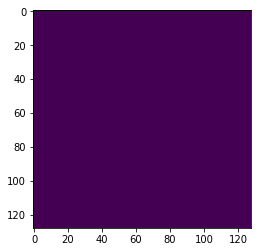

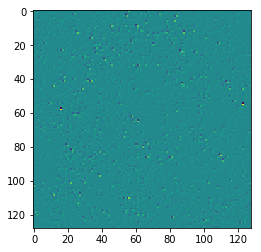

In [33]:
plt.imshow((tmpnn-hmeshnn)[...].sum(axis=0))
plt.show()
plt.imshow((tmpnn-hmeshnn2)[...].sum(axis=0))
plt.show()


In [34]:
# def fftk(shape, boxsize, symmetric=True):
#     """                                                                                                                                                                         
                                                                                                                                                                                
#     """
#     k = []
#     for d in range(len(shape)):
#         kd = numpy.fft.fftfreq(shape[d])
#         kd *= 2 * numpy.pi / boxsize * shape[d]
#         kdshape = numpy.ones(len(shape), dtype='int')
#         if symmetric and d == len(shape) -1:
#             kd = kd[:shape[d]//2 + 1]
#         kdshape[d] = len(kd)
#         kd = kd.reshape(kdshape)

#         k.append(kd)
#     kk = sum([i ** 2 for i in k])
#     for i in k:
#         del i
#     del k, kd, kdshape
#     return kk ** 0.5





In [136]:
importlib.reload(tools)

<module 'tools' from '/global/homes/c/chmodi/Programs/cosmo4d/train_nets-tflow/tools.py'>

In [124]:
# kmesh = tools.fftk(ar.shape, bs)
# kmeshfn = tools.fftk(ar.shape, bs, finite=True)
# kmesh2 = np.sum([kk**2 for kk in mesh.r2c().x])**0.5
kk = tools.fftk(ar.shape, bs)

In [125]:
arc = np.fft.rfftn(ar)/np.prod(ar.shape)
meshc = mesh.r2c()

In [126]:
arr = np.fft.irfftn(arc) * np.prod(ar.shape)

In [127]:
meshr = meshc.c2r()

In [130]:
kny = np.pi*nc/bs
arg = tools.fingauss(ar, kk, 3, kny=kny)
meshg = ft.smooth(mesh, 3, 'fingauss')

In [131]:
abs(arg - meshg)[...].max()


2.5904625125527936e-07

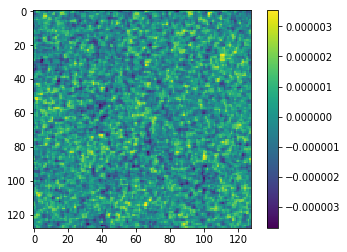

In [132]:
plt.imshow((arg-meshg[...]).sum(axis=0))
plt.colorbar()

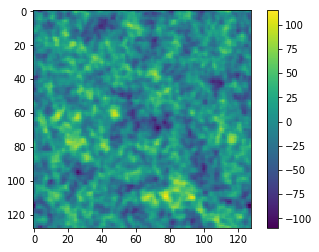

In [133]:
plt.imshow(meshg[...].sum(axis=-1))
plt.colorbar()

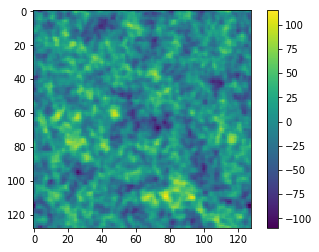

In [134]:
plt.imshow(arg[...].sum(axis=-1))
plt.colorbar()

In [103]:
(meshg[...] == 0).sum()

0

In [137]:
meshd = ft.decic(mesh)
ard = tools.decic(ar, kk, kny)

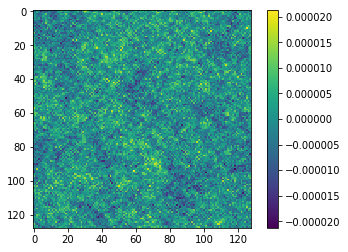

In [140]:
plt.imshow((ard-meshd)[...].sum(axis=0))
plt.colorbar()

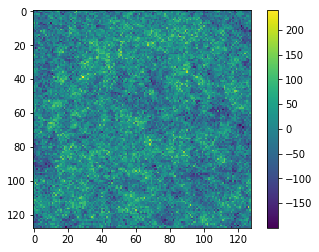

In [139]:
plt.imshow(meshd[...].sum(axis=0))
plt.colorbar()

In [144]:
abs(ard - meshd).csum()

1.0415125688612692

In [150]:
pm.mesh_coordinates().shape

(2097152, 3)

In [151]:
np.array(np.where(ar)).T.shape

(2097152, 3)

In [156]:
np.arange(0.9, 1.1, 0.01).size

21